## Setting the environment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
%cd /content/drive/MyDrive/Group_1_2024_Children_Sentiment_Analysis
! ls

/content/drive/MyDrive/B.Tech_Course_Project/Group_1_2024_Children_Sentiment_Analysis
4000-Stories-with-sentiment-analysis.xlsx  Group_1_2024_Children_Stories_Sentiment_Analysis.ipynb


## Importing the essential libraries

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading the 4000 children Stories Dataset

In [16]:
file_path = '4000-Stories-with-sentiment-analysis.xlsx'
data = pd.read_excel(file_path)

## Data Cleaning and EDA

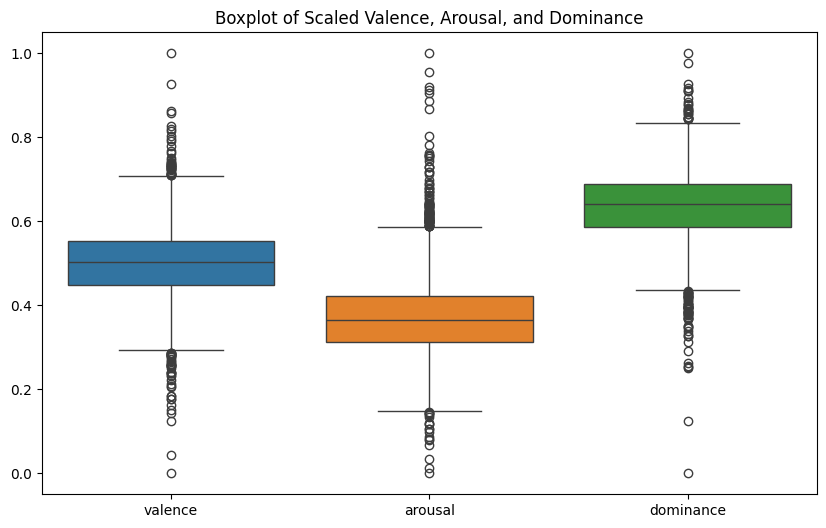

In [10]:
# Initialize VADER sentiment analyzer and scaling
sia = SentimentIntensityAnalyzer()
scaler = MinMaxScaler()

# Fill missing 'story' values with an empty string
data['processed_text'] = data['processed_text'].fillna("")

# Scale valence, arousal, and dominance
data[['valence', 'arousal', 'dominance']] = scaler.fit_transform(data[['valence', 'arousal', 'dominance']])

# Visualization of scaled features
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['valence', 'arousal', 'dominance']])
plt.title('Boxplot of Scaled Valence, Arousal, and Dominance')
plt.show()

# Text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\<.*?\>', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    return " ".join(tokens)

# Apply text cleaning
data['cleaned_text'] = data['processed_text'].apply(clean_text)

## Sentiment Labeling using VADER (Valence Aware Dictionary and Sentiment Reasoner)

In [11]:
# Sentiment labeling
def label_sentiment(text):
    polarity_score = sia.polarity_scores(text)['compound']
    if polarity_score > 0.5:
        return 1
    elif polarity_score < 0.5:
        return 0

data['sentiment_label'] = data['cleaned_text'].apply(label_sentiment)

## Saving the processed data as CSV

In [ ]:
data.to_csv("4000_Children_Stories_Processed.csv", index=False)

## Loading the processed data and Doc2Vec word-embeddings

In [12]:
data = pd.read_csv("4000_Children_Stories_Processed.csv")
X = data[[str(i) for i in range(300)]]  # Selecting columns 0 to 299 as features
y = data['sentiment_label']  # The target label column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Print the shapes to confirm
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3256, 1, 300)
X_test shape: (815, 1, 300)
y_train shape: (3256,)
y_test shape: (815,)


In [13]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


# Bayesian Optimization

Bayesian optimization is a method for optimizing functions that are expensive to evaluate, commonly used for hyperparameter tuning in machine learning. It models the objective function using a probabilistic surrogate, often a Gaussian Process, which predicts the function’s output based on prior evaluations.

1. **Surrogate Model**: A Gaussian Process estimates the objective function, providing a distribution of possible values.
2. **Acquisition Function**: This function selects the next hyperparameter set to evaluate, balancing exploration (testing uncertain areas) and exploitation (refining known high-performing areas).
3. **Iteration**: The model iteratively updates based on evaluations, refining predictions for optimal hyperparameters.

---

# Binary Cross-Entropy

Binary Cross-Entropy is a loss function used in binary classification tasks to measure the accuracy of predicted probabilities.

### Advantages:
1. Penalizes incorrect predictions based on how confident the model is.
2. Encourages the model to output probabilities close to the actual labels.


In [14]:
import optuna

# Define the model structure
def build_model(lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Input(shape=(1, 300)))

    # LSTM layers
    for _ in range(8):  # 8 LSTM layers
        model.add(LSTM(lstm_units, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

# Objective function for Bayesian Optimization
def objective(trial):
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    model = build_model(lstm_units, dropout_rate, learning_rate)
    model.fit(X_train, y_train, epochs=3, batch_size=64, verbose=0, validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[0]  # Validation loss as objective

# Run Bayesian optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Train the optimized model with the best hyperparameters and save it
optimised_model = build_model(
    lstm_units=best_params["lstm_units"],
    dropout_rate=best_params["dropout_rate"],
    learning_rate=best_params["learning_rate"]
)

# Train the optimised model fully on the training data
optimised_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

[I 2024-11-12 13:39:17,286] A new study created in memory with name: no-name-93fe61a5-dbb1-493a-bba8-6e7d72abf956
<ipython-input-14-f9af7a78813c>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
[I 2024-11-12 13:39:31,104] Trial 0 finished with value: 0.5278581976890564 and parameters: {'lstm_units': 127, 'dropout_rate': 0.1820957214686728, 'learning_rate': 0.00013273050974839653}. Best is trial 0 with value: 0.5278581976890564.
[I 2024-11-12 13:39:40,207] Trial 1 finished with value: 0.4433402717113495 and parameters: {'lstm_units': 46, 'dropout_rate': 0.4587396046492781, 'learning_rate': 0.0017633776995381691}. Best is trial 1 with value: 0.4433402717113495.
[I 2024-11-12 13:39:49,731] Trial 2 finished with value: 0.39335525035858154 and parameters: {'lstm

Best hyperparameters:  {'lstm_units': 44, 'dropout_rate': 0.3274103603921039, 'learning_rate': 0.003994839769149309}
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7847 - loss: 0.5916 - val_accuracy: 0.8160 - val_loss: 0.4845
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8209 - loss: 0.4773 - val_accuracy: 0.8160 - val_loss: 0.4317
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8402 - loss: 0.3727 - val_accuracy: 0.8160 - val_loss: 0.4259
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8284 - loss: 0.3360 - val_accuracy: 0.7623 - val_loss: 0.4099
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8973 - loss: 0.2421 - val_accuracy: 0.7715 - val_loss: 0.4881
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9229 - loss: 0.2033 - val_accuracy: 0.8113 - val_loss: 0.4527
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9576 - loss: 0.1238 - val_accuracy: 0.8282 - val_loss: 0

## Saving the optimised model

In [17]:
optimised_model.save("optimised_model.keras")

## Feature Extraction from LSTM Layers

In [18]:
# Extract LSTM features
feature_extractor = Sequential(optimised_model.layers[:-3])  # Excluding the last Dense layers
X_train_lstm_features = feature_extractor.predict(X_train)
X_train_lstm_features = X_train_lstm_features.reshape(X_train_lstm_features.shape[0], -1)

# If needed, reshape X_test_lstm_features as well (assuming you extract features for the test set)
X_test_lstm_features = feature_extractor.predict(X_test)
X_test_lstm_features = X_test_lstm_features.reshape(X_test_lstm_features.shape[0], -1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


## PCA on the Extracted Features

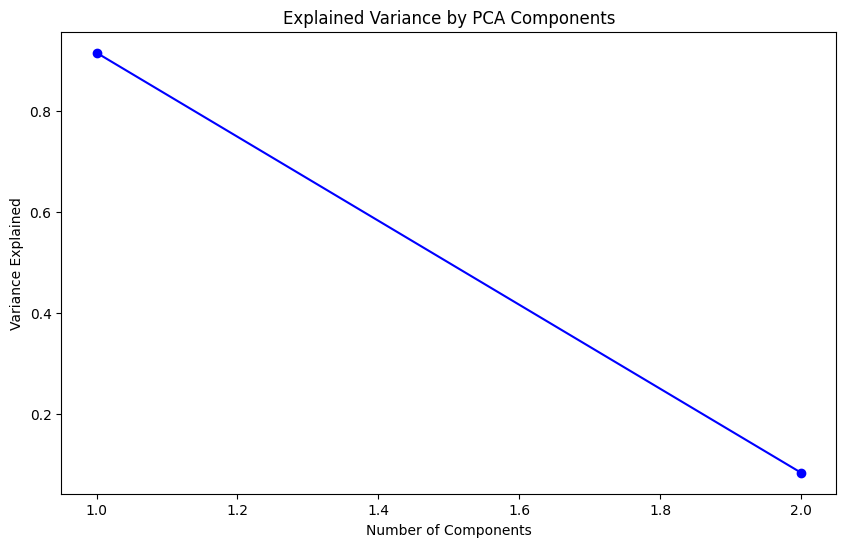

RandomForestClassifier(random_state=42)

In [19]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of LSTM features
pca = PCA(n_components=.95)  # Keep components explaining 95% of variance
X_train_pca = pca.fit_transform(X_train_lstm_features)
X_test_pca = pca.transform(X_test_lstm_features)

# Explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', color='b')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()

# Train a Random Forest Classifier on the PCA features
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_rf, y_train_rf)

## Prediction on the Test Data using Random Forest

In [20]:
# Make predictions and evaluate
y_pred_rf = rf_clf.predict(X_test_rf)
accuracy = accuracy_score(y_test_rf, y_pred_rf)
print(f'Random Forest Classifier Accuracy (with PCA): {accuracy:.4f}')

Random Forest Classifier Accuracy (with PCA): 0.9233


## Performance Analysis

Confusion Matrix:


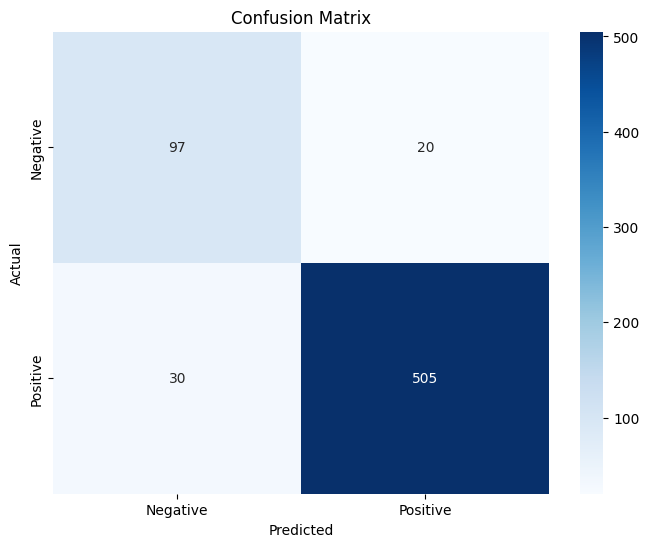

In [22]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_rf, y_pred_rf)

# Print the confusion matrix
print("Confusion Matrix:")

# You can also visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(classification_report(y_test_rf, y_pred_rf))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80       117
           1       0.96      0.94      0.95       535

    accuracy                           0.92       652
   macro avg       0.86      0.89      0.87       652
weighted avg       0.93      0.92      0.92       652

